# Inference


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_57495/2033846779.py:7: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [2]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df["therapy_length_days"] = (
        pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
    ).dt.days

    df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
    df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

    df["ActivityDateTime"] = pd.to_datetime(df["ActivityDateTime"])
    df["therapy_week"] = df.groupby("dyad")["ActivityDateTime"].transform(
        lambda x: (x - x.min()).dt.days // 7
    )

    # Select features
    df = df.drop(
        [
            "ActivityDateTime",
            "DurationInSeconds",  # total active time
            "SleepMorningDate",
            "Diagnosis",
            "CDI start date",
            "PDI start date",
            "PDI end date",
            # "Medication ",
            "Type of medication",
            "Medication start date",
            "Week",
            "Therapy session",
            "Therapy Start",
            "Therapy End",
            "Education Status",
            "Parental Status",
            "Pre.ECBI",
            "Pre.ECBI.Prob",
            "Post.ECBI",
            "Post.ECBI.Prob",
            "QuitStudy",
            "Employment Status",
            "ParticipatingParent.Sex",
            "Parent-PhoneType",
            # Data that is only available as "real time data" (more battery use?) in Companion SDK
            # NOTE: Removing these actually improves model accuracy?
            "DistanceInMeters",
            "ActiveKilocalories",
            "METmins",
            "METavg",
            "activity_seconds_sedentary",
            "activity_seconds_active",
            "activity_seconds_highly_active",
        ]
        # moving window stats
        + [
            "hr_moving_avg_15m",
            "hr_moving_std_15m",
            "hr_moving_min_15m",
            "hr_moving_max_15m",
            "hr_moving_avg_30m",
            "hr_moving_std_30m",
            "hr_moving_min_30m",
            "hr_moving_max_30m",
            "hr_moving_avg_45m",
            "hr_moving_std_45m",
            "hr_moving_min_45m",
            "hr_moving_max_45m",
        ],
        axis=1,
    )
    df = df.drop([col for col in df.columns if col.startswith("hr-prev")], axis=1)

    def yn_to_bool(df):
        """
        Convert columns with 'Y'/'N' strings to boolean True/False.
        """
        for col in df.columns:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
                df[col] = df[col].map({"Y": True, "N": False})
        return df

    df = yn_to_bool(df)

    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df


def prep_X_y(df: pd.DataFrame, response_column: str) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(
        [
            "tantrum_within_60m",
            "tantrum_within_45m",
            "tantrum_within_30m",
            "tantrum_within_15m",
            # Useful for indexing
            "Arm_Sham",
            "dyad",
            "therapy_week",
        ],
        axis=1,
    )
    y = df[response_column].astype(int)
    return X, y

In [3]:
from sklearn.model_selection import train_test_split

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_df = clean_data(sorted_dyads_df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]

df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=False)
X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
X_val, y_val = prep_X_y(df_val, "tantrum_within_60m")

df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]
X_test, y_test = prep_X_y(df_test, "tantrum_within_60m")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_57495/3432719691.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


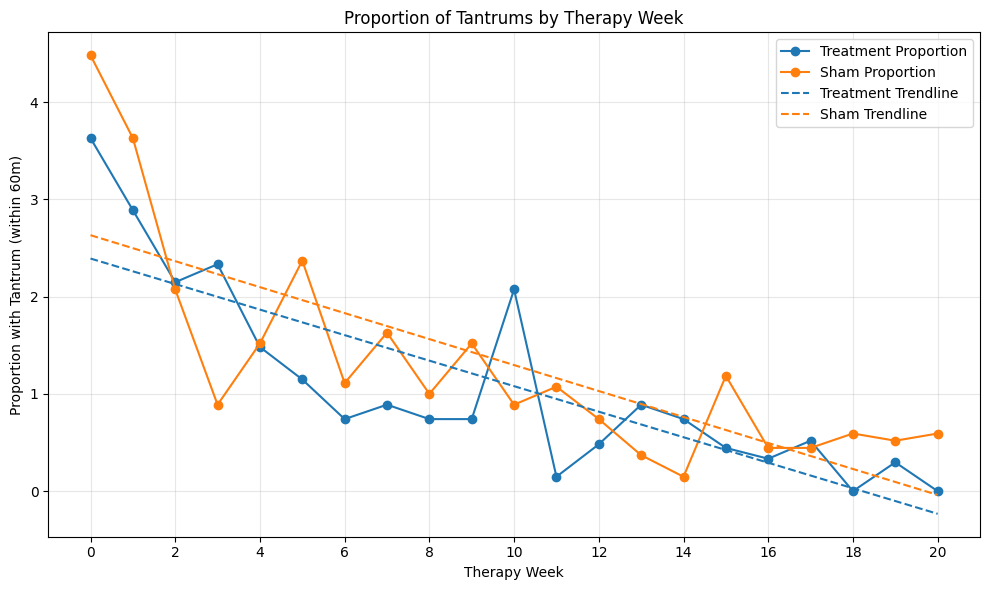

In [6]:
import matplotlib.pyplot as plt
import numpy as np

week_cutoff = 20
test_tantrum_proportion = (
    df_test.groupby("therapy_week")["tantrum_within_60m"].sum()
    / df_test["dyad"].nunique()
)
test_tantrum_proportion = test_tantrum_proportion[
    test_tantrum_proportion.index <= week_cutoff
]

train_tantrum_proportion = (
    df_train.groupby("therapy_week")["tantrum_within_60m"].sum()
    / df_test["dyad"].nunique()
)
train_tantrum_proportion = train_tantrum_proportion[
    train_tantrum_proportion.index <= week_cutoff
]

plt.figure(figsize=(10, 6))
plt.plot(
    test_tantrum_proportion.index,
    test_tantrum_proportion.values,
    label="Treatment Proportion",
    marker="o",
)
plt.plot(
    train_tantrum_proportion.index,
    train_tantrum_proportion.values,
    label="Sham Proportion",
    marker="o",
)

# Add trendlines
z_test = np.polyfit(test_tantrum_proportion.index, test_tantrum_proportion.values, 1)
p_test = np.poly1d(z_test)
plt.plot(
    test_tantrum_proportion.index,
    p_test(test_tantrum_proportion.index),
    label="Treatment Trendline",
    linestyle="--",
    color="tab:blue",
)

z_train = np.polyfit(train_tantrum_proportion.index, train_tantrum_proportion.values, 1)
p_train = np.poly1d(z_train)
plt.plot(
    train_tantrum_proportion.index,
    p_train(train_tantrum_proportion.index),
    label="Sham Trendline",
    linestyle="--",
    color="tab:orange",
)

plt.xlabel("Therapy Week")
plt.xticks(np.arange(0, week_cutoff + 1, 2))
plt.ylabel("Proportion with Tantrum (within 60m)")
plt.title("Proportion of Tantrums by Therapy Week")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.base import BaseEstimator


class HrModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        mean_hr = X["hr_moving_avg_60m"]
        return (mean_hr > 80) & (mean_hr < 129)

    def predict_proba(self, X):
        preds = self.predict(X)
        proba = np.zeros((len(X), 2))
        proba[:, 1] = preds.astype(float)
        proba[:, 0] = 1 - proba[:, 1]
        return proba


class PositiveModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return np.ones(len(X), dtype=bool)

    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        proba[:, 1] = 1.0
        proba[:, 0] = 0.0
        return proba


class CoinFlipModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.predict_proba(X)[:, 1] >= 0

    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        mid = len(proba) // 2
        proba[:mid, 1] = 1
        proba[mid:, 1] = -1
        proba[:, 0] = 1 - proba[:, 1]
        return proba

In [8]:
from flaml import AutoML
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit()
automl = AutoML()


automl_settings = {
    "time_budget": 60,  # seconds
    "train_time_limit": 30,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    "split_type": time_series_split,
    "early_stop": True,
}


automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

[flaml.automl.logger: 12-15 13:09:25] {1752} INFO - task = classification
[flaml.automl.logger: 12-15 13:09:25] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 12-15 13:09:25] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 12-15 13:09:25] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-15 13:09:25] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-15 13:09:25] {2417} INFO - Estimated sufficient time budget=2801s. Estimated necessary time budget=3s.
[flaml.automl.logger: 12-15 13:09:25] {2466} INFO -  at 0.8s,	estimator xgboost's best error=0.0268,	best estimator xgboost's best error=0.0268
[flaml.automl.logger: 12-15 13:09:25] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-15 13:09:25] {2466} INFO -  at 1.1s,	estimator xgboost's best error=0.0268,	best estimator xgboost's best error=0.0268
[flaml.automl.logger: 12-15 13:09:25] {2282} INFO - iteration 2, current 

In [9]:
from sklearn.metrics import precision_score, recall_score

hr_model = HrModel()
hr_model.fit(X_train, y_train)

ref_y_pred = hr_model.predict(X_val)
ref_precision = precision_score(y_val, ref_y_pred, zero_division=np.nan)
ref_recall = recall_score(y_val, ref_y_pred, zero_division=np.nan)

y_pred_proba = automl.predict_proba(X_val)
thresholds = np.logspace(-10, 0, 100)

threshold = None
for th in thresholds:
    y_pred = (y_pred_proba[:, 1] >= th).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=np.nan)
    recall = recall_score(y_val, y_pred, zero_division=np.nan)
    if precision >= ref_precision:
        print(f"Selected threshold: {th} with precision: {precision}, recall: {recall}")
        print(f"Reference precision: {ref_precision}, recall: {ref_recall}")
        threshold = th
        break

assert threshold is not None, "No suitable threshold found!"

Selected threshold: 0.001873817422860383 with precision: 0.005475880052151239, recall: 0.9692307692307692
Reference precision: 0.005097495793328714, recall: 0.7923076923076923


In [ ]:
from shap.models import Model
from typing import Any

import xgboost as xgb
from tqdm.auto import tqdm


def train_model(df):
    X_train, y_train = prep_X_y(df, "tantrum_within_60m")
    model = xgb.XGBClassifier(**automl.best_config)
    model.fit(X_train, y_train)
    return model


def train_and_get_dyad_models(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    base_model,
    mode: str,
    week: int,
    dyad_models: dict[str, Any],
):
    min_week = df_test["therapy_week"].min()
    new_dyad_models = {}
    dyads = df_test["dyad"].unique()

    bootstrap_level = len(dyads)
    match mode:
        case "coin_flip_model":
            for dyad in dyads:
                new_dyad_models[dyad] = CoinFlipModel()
        case "hr_model":
            for dyad in dyads:
                new_dyad_models[dyad] = HrModel()
        case "no_retrain":
            for dyad in dyads:
                new_dyad_models[dyad] = base_model
        case "retrain_dyad":
            for dyad, dyad_df in df_test.groupby("dyad"):
                additional_df = dyad_df[dyad_df["therapy_week"] < week]
                boot_df = pd.DataFrame()
                for _ in range(bootstrap_level):
                    boot_df = pd.concat(
                        [
                            boot_df,
                            additional_df.sample(
                                frac=1, replace=True, random_state=None
                            ),
                        ]
                    )
                df_concat = pd.concat([df_train, boot_df])
                model = train_model(df_concat)
                new_dyad_models[dyad] = model
        case "iter_retrain_dyad":
            if week == min_week:
                for dyad in dyads:
                    new_dyad_models[dyad] = base_model
            else:
                for dyad, dyad_df in df_test.groupby("dyad"):
                    additional_df = dyad_df[dyad_df["therapy_week"] == week - 1]
                    boot_df = pd.DataFrame()
                    for _ in range(bootstrap_level):
                        boot_df = pd.concat(
                            [
                                boot_df,
                                additional_df.sample(
                                    frac=1, replace=True, random_state=None
                                ),
                            ]
                        )
                    X_train, y_train = prep_X_y(boot_df, "tantrum_within_60m")
                    model = dyad_models[dyad]
                    # Iterative retraining
                    new_model = xgb.XGBClassifier(**automl.best_config)

                    print(
                        f"Number of trees: {model.get_booster().num_boosted_rounds()}"
                    )

                    new_dyad_models[dyad] = new_model
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(df_train: pd.DataFrame, df_test: pd.DataFrame, mode: str):
    base_model = train_model(df_train)

    dyad_models = {}
    weekly_results = []
    for week in tqdm(sorted(df_test["therapy_week"].unique())):
        dyad_models = train_and_get_dyad_models(
            df_train, df_test, base_model, mode, week, dyad_models=dyad_models
        )
        week_df = df_test[df_test["therapy_week"] == week]

        week_preds = np.array([])
        week_trues = np.array([])
        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])

        weekly_results.append((week, week_preds, week_trues))
    return weekly_results


In [ ]:
coin_flip_model_results = retrain_and_predict(df_train, df_test, mode="coin_flip_model")

In [ ]:
hr_model_results = retrain_and_predict(df_train, df_test, mode="hr_model")

In [ ]:
no_retrain_results = retrain_and_predict(df_train, df_test, mode="no_retrain")

In [43]:
iter_retrain_dyad_results = retrain_and_predict(
    df_train, df_test, mode="iter_retrain_dyad"
)

  0%|          | 0/26 [00:00<?, ?it/s]

Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 362
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of trees: 724
Number of tre

KeyboardInterrupt: 

In [25]:
retrain_dyad_results = retrain_and_predict(df_train, df_test, mode="retrain_dyad")

  0%|          | 0/26 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt

# Compute recall for each week for hr_model_results and no_retrain_results
hr_recalls = [
    recall_score(y_true, y_pred, zero_division=0)
    for _, y_pred, y_true in hr_model_results
]
no_retrain_recalls = [
    recall_score(y_true, y_pred, zero_division=0)
    for _, y_pred, y_true in no_retrain_results
]
iter_retrain_recalls = [
    recall_score(y_true, y_pred, zero_division=0)
    for _, y_pred, y_true in iter_retrain_dyad_results
]

weeks = [int(week) for week, _, _ in hr_model_results]

plt.figure(figsize=(10, 6))
plt.plot(weeks, hr_recalls, label="HR Model Recall", marker="o")
plt.plot(weeks, no_retrain_recalls, label="No Retrain Recall", marker="o")
plt.plot(weeks, iter_retrain_recalls, label="Iterative Retrain Recall", marker="o")
plt.xlabel("Therapy Week")
plt.ylabel("Recall")
plt.title("Recall by Therapy Week")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pickle

data_dir = Path("./intermediate_data")
data_dir.mkdir(exist_ok=True)

with open(data_dir / "coin_flip_model_results.pkl", "wb") as f:
    pickle.dump(coin_flip_model_results, f)

with open(data_dir / "hr_model_results.pkl", "wb") as f:
    pickle.dump(hr_model_results, f)

with open(data_dir / "no_retrain_results.pkl", "wb") as f:
    pickle.dump(no_retrain_results, f)

with open(data_dir / "retrain_dyad_results.pkl", "wb") as f:
    pickle.dump(retrain_dyad_results, f)

with open(data_dir / "iter_retrain_dyad_results.pkl", "wb") as f:
    pickle.dump(iter_retrain_dyad_results, f)

DECIDED

-   recall is more important than precision -- if we achieve the same precision as pistachio 1.0 that's good enough

TODO

-   weekly performance, only show best model, weeks 0 to 20
-   run variations of prediction window (lookahead) + frequency, plot of sensitivity by frequency/lookahead
-   sensitivity + specificity + AUC+ROC
-   do weekly versions + trendline, not cum
-   for manuscript -- use terms e.g., "scheduled retraining", "closed loop"
-   why even do online learning -- capture "in situ" context, don't simply apply historical model to new cohort
-   experiment with oversampling recent data (or sample weighting, focus on the positive observations)
    -   look into regret minimization algos


# Analysis


In [ ]:
from pathlib import Path
import pickle

data_dir = Path("./intermediate_data")
with open(data_dir / "coin_flip_model_results.pkl", "rb") as f:
    coin_flip_model_results = pickle.load(f)

with open(data_dir / "hr_model_results.pkl", "rb") as f:
    hr_model_results = pickle.load(f)

with open(data_dir / "no_retrain_results.pkl", "rb") as f:
    no_retrain_results = pickle.load(f)

with open(data_dir / "retrain_dyad_results.pkl", "rb") as f:
    retrain_dyad_results = pickle.load(f)

with open(data_dir / "iter_retrain_dyad_results.pkl", "rb") as f:
    iter_retrain_dyad_results = pickle.load(f)